## Sentinel-1 Flooding

This notebook uses Sentinel-1 data to detect water extent and flooding. Since radar can penetrate clouds, it is possible to get consistent time series views of a region at 6-day or 12-day revisits based on the use of one or two Sentinel-1 missions. If the region of interest falls within a scene overlap, it may be possible to get even more frequent visits. This notebook includes several different data products including histograms to find a good threshold for water detection, a single date VH-band threshold product to identify water extent, and a multi-date change product to identify new flooding. For more information about how to interpret radar data, see the following document <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>(HERE)</b></a>: "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data"

## Load common Tools and Utilities

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio.features
import pandas as pd
import geopandas as gpd

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer as pc

# Import Open Data Cube (ODC) tools
import odc 
from odc.stac import stac_load

# Import Open Data Cube (ODC) utilities
# Contains RGB functions and Statistics functions
# The ODC_Utilities folder (and files) should be stored in the same directory as this notebook
from ODC_Utilities.odc_rgb import rgb
from ODC_Utilities.figures import figure_ratio, retrieve_or_create_fig_ax, get_ax_size, xarray_set_axes_labels
from ODC_Utilities.statistics import stats_filter_2d

## Define the Extents of the Analysis
Select the center of an analysis region (lat_long) below. The size of the region (in degrees) that surrounds this center point is defined using the "box_size_deg" parameter. Users can select one of the example regions or add a new region. After selecting an analysis region, select a time window by defining the start date/end date for the "time_of_interest" parameter. Consistent Sentinel-1 time series data is available from Jan-2017. To avoid issues with exceeding memory limits, users should start with small regions (<0.20 degrees) and small time windows (a few months) before expanding to larger analyses.

In [2]:
# Sample Rice Crop Field in An Giang, Vietnam
# lat_long = (10.4657, 105.3579) # Lat-Lon centroid location
# box_size_deg = 0.07 # Surrounding box in degrees
# time_of_interest = "2023-03-15/2023-04-01"

# Example #1 - Macuspana, Tabasco, Mexico
# Flooded on 04-Oct from Tropical Storm Gamma
# Flooded on 09-Nov from Tropical Storm Eta
# Time Extents = 2020-09-01 to 2020-12-31 (~3 months)
# Orbit Path = 99

lat_long = (17.713, -92.595) # Lat-Lon centroid location
box_size_deg = 0.20 # Small region box in degrees
time_of_interest = "2020-09-01/2020-12-31"

# lat_long = (18.0, -92.67) # Lat-Lon centroid location
# box_size_deg = 1.0 # Large region box in degrees
# time_of_interest = "2020-09-01/2021-02-01"

# Example #2 - Campur, Guatemala
# Rains started on Nov 3, 2020 (Tropical Storm Eta)
# Rains ended on Nov 17, 2020 (Tropical Storm Iota)
# Time Extents = 2020-10-30 to 2021-01-24 (~3 months)
# Orbit Path = 136

# lat_long = (15.6339, -90.0471) # Lat-Lon centroid location
# box_size_deg = 0.02 # Surrounding box in degrees
# time_of_interest = "2020-10-30/2021-01-24"

# Example #3 - Lismore, NSW, Australia
# Major Flood Event (Feb 28, 2022)

# lat_long = (-28.8065, 153.2752) # Lat-Lon centroid location
# box_size_deg = 0.03 # Surrounding box in degrees
# time_of_interest = "2022-01-15/2022-04-15"

In [3]:
# Calculate a bounding box
min_lon = lat_long[1]-box_size_deg/2
min_lat = lat_long[0]-box_size_deg/2
max_lon = lat_long[1]+box_size_deg/2
max_lat = lat_long[0]+box_size_deg/2
bbox = (min_lon, min_lat, max_lon, max_lat)

## Search the Archive for Data
Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes. 

In [4]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest)
items = list(search.get_all_items()) # This produces a list of scene IDs

In [5]:
print('Total scenes =',len(items))

Total scenes = 77


## Review the Details of Data

In [6]:
# List the detailed filenames (if desired)
# list(items)

In [7]:
# List the properties for any specific scene (number in brackets)
# We will filter our search using these properties later
# items[0].properties

In [8]:
# Display a table with the scene dates, orbit direction, and orbit number
# Different orbit numbers have different viewing geometries
# We will pick consistent orbit numbers to detect change and find water

# Set the maximum rows in the table
pd.set_option('display.max_rows', 250) 

# Select the properties we want in our table
passes = gpd.GeoDataFrame.from_features(items, columns=['datetime','sat:orbit_state','sat:relative_orbit'])

#Cast geojson datetime property to true datetime format and convert to only the date
passes['datetime'] = pd.to_datetime(passes['datetime'])
passes['datetime'] = passes['datetime'].dt.date

#Reformat Column titles for readability
passes.rename(columns={'datetime':'Date','sat:orbit_state':'Orbit Direction',
                       'sat:relative_orbit':"Orbit Number"}, inplace=True)

#Display dataframe
passes

Date Orbit Direction  Orbit Number
0   2020-12-30       ascending           136
1   2020-12-29       ascending            34
2   2020-12-29       ascending            34
3   2020-12-27      descending            99
4   2020-12-24       ascending           136
5   2020-12-24       ascending           136
6   2020-12-23       ascending            34
7   2020-12-21      descending            99
8   2020-12-18       ascending           136
9   2020-12-17       ascending            34
10  2020-12-17       ascending            34
11  2020-12-15      descending            99
12  2020-12-12       ascending           136
13  2020-12-12       ascending           136
14  2020-12-11       ascending            34
15  2020-12-09      descending            99
16  2020-12-06       ascending           136
17  2020-12-05       ascending            34
18  2020-12-05       ascending            34
19  2020-12-03      descending            99
20  2020-11-30       ascending           136
21  2020-11-30       ascending           136
22  2020-11-29       ascending            34
23  2020-11-27      descending            99
24  2020-11-24       ascending           136
25  2020-11-23       ascending            34
26  2020-11-23       ascending            34
27  2020-11-21      descending            99
28  2020-11-18       ascending           136
29  2020-11-18       ascending           136
30  2020-11-17       ascending            34
31  2020-11-15      descending            99
32  2020-11-12       ascending           136
33  2020-11-11       ascending            34
34  2020-11-11       ascending            34
35  2020-11-09      descending            99
36  2020-11-06       ascending           136
37  2020-11-06       ascending           136
38  2020-11-05       ascending            34
39  2020-11-03      descending            99
40  2020-10-31       ascending           136
41  2020-10-30       ascending            34
42  2020-10-30       ascending            34
43  2020-10-25       ascending           136
44  2020-10-25       ascending           136
45  2020-10-24       ascending            34
46  2020-10-22      descending            99
47  2020-10-19       ascending           136
48  2020-10-18       ascending            34
49  2020-10-18       ascending            34
50  2020-10-16      descending            99
51  2020-10-13       ascending           136
52  2020-10-13       ascending           136
53  2020-10-12       ascending            34
54  2020-10-10      descending            99
55  2020-10-07       ascending           136
56  2020-10-06       ascending            34
57  2020-10-06       ascending            34
58  2020-10-04      descending            99
59  2020-10-01       ascending           136
60  2020-10-01       ascending           136
61  2020-09-28      descending            99
62  2020-09-25       ascending           136
63  2020-09-24       ascending            34
64  2020-09-24       ascending            34
65  2020-09-22      descending            99
66  2020-09-18       ascending            34
67  2020-09-16      descending            99
68  2020-09-13       ascending           136
69  2020-09-12       ascending            34
70  2020-09-12       ascending            34
71  2020-09-10      descending            99
72  2020-09-07       ascending           136
73  2020-09-07       ascending           136
74  2020-09-06       ascending            34
75  2020-09-04      descending            99
76  2020-09-01       ascending           136

## Select Consistent Data

In [9]:
# Adjust the search to only include one specific relative orbit. This will maintain consistent viewing geometries.
# Look for a consistent repeat cycle of 6 days (2 missions) or 12 days (one mission)
# See Block-2 (Analysis Extents) for details on orbit numbers for the sample case studies

catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest, 
                        query={"sat:relative_orbit": {"eq": 99}})
items2 = list(search.get_all_items()) # This produces a list of scene IDs

In [10]:
print('Total scenes =',len(items2))

Total scenes = 19


In [11]:
# List the detailed filenames (if desired)
# list(items2)

In [12]:
# Display an updated table with the scene dates and consistent orbit numbers

# Set the maximum rows in the table
pd.set_option('display.max_rows', 250) 

# Select the properties we want in our table
passes2 = gpd.GeoDataFrame.from_features(items2, columns=['datetime','sat:orbit_state','sat:relative_orbit'])

#Cast geojson datetime property to true datetime format and convert to only the date
passes2['datetime'] = pd.to_datetime(passes2['datetime'])
passes2['datetime'] = passes2['datetime'].dt.date

#Reformat Column titles for readability
passes2.rename(columns={'datetime':'Date','sat:relative_orbit':"Orbit Number"}, inplace=True)

#Display dataframe
passes2

Date sat:orbit_state  Orbit Number
0   2020-12-27      descending            99
1   2020-12-21      descending            99
2   2020-12-15      descending            99
3   2020-12-09      descending            99
4   2020-12-03      descending            99
5   2020-11-27      descending            99
6   2020-11-21      descending            99
7   2020-11-15      descending            99
8   2020-11-09      descending            99
9   2020-11-03      descending            99
10  2020-10-22      descending            99
11  2020-10-16      descending            99
12  2020-10-10      descending            99
13  2020-10-04      descending            99
14  2020-09-28      descending            99
15  2020-09-22      descending            99
16  2020-09-16      descending            99
17  2020-09-10      descending            99
18  2020-09-04      descending            99

## Load the Data into an XARRAY Data Cube

Next, we'll load the selected data into an [xarray](https://xarray.pydata.org/en/stable/) using [stackstac](https://stackstac.readthedocs.io/) and then "clip" the data to only the pixels within our region (bounding box). We will only keep the desired bands, VV and VH. There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees and we have specified the spatial resolution of each pixel. In order to run large-scale analyses where you are searching large areas for flooding, it is best ot select 100-meters for the resolution. The baseline resolution for Sentinel-1 data is 10-meters. 

In [13]:
# Define the pixel resolution for the loaded data. 
# Use 100-meters for large analyses and 10-meters for detailed analyses. 
# Define the scale according to our selected CRS, so we will use degrees

resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [14]:
# Load the data using Open Data Cube
# Select the correct items list to get consistent orbit paths
data = stac_load(items2,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox, 
                 crs="EPSG:4326", resolution=scale, groupby="solar_day", resampling='average')

In [15]:
# View the details of our xarray dataset
# The X and Y dimensions tell us the pixel dimensions of our bounding box
# The "time" variable is the number of scenes that touch our region
data

<xarray.Dataset>
Dimensions:      (latitude: 2228, longitude: 2227, time: 19)
Coordinates:
  * latitude     (latitude) float64 17.81 17.81 17.81 ... 17.61 17.61 17.61
  * longitude    (longitude) float64 -92.69 -92.69 -92.69 ... -92.5 -92.5 -92.5
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2020-09-04T12:01:17.192197 ... 2020-12...
Data variables:
    vv           (time, latitude, longitude) float32 0.1122 0.1811 ... 0.1626
    vh           (time, latitude, longitude) float32 0.02837 0.03953 ... 0.05619

### Apply Speckle Filtering using a Block Average Filter
Radar data is often "grainy" in appearance due to speckle (statistical noise). To improve the data, it is quite common to use speckle filtering. Below is an algorithm that uses a common "block averaging" filter to average the pixels surrounding any given pixel. Users can select an odd number filter window size (e.g. 3,5,7, etc.) to filter both the VV and VH data. A filter window size of 3 will average a 3x3 region around every pixel. Similarly, a filter window size of 5 will average a 5x5 region around a every pixel. 

In [16]:
# Power to dB conversion function

def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

In [17]:
# Users can select the block average filter size to define the level of speckle filtering. The baseline is 5.
# The filter size must be an odd number, such as 3,5,7, etc. 
# See the odc_utilities file for the stats_filter_2d function

block_size = 3

# Set any null values to 0 before applying the filter to prevent issues
data_filled = data.where(~data.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data and convert to dB units
data["filter_vv"] = data_filled.vv.groupby("time").apply(stats_filter_2d, statistic='mean', filter_size=block_size).pipe(power_to_db)
data["filter_vh"] = data_filled.vh.groupby("time").apply(stats_filter_2d, statistic='mean', filter_size=block_size).pipe(power_to_db)

## View Histogram Plots
Histogram plots are good for viewing the statistical backscatter distribution of the VV and VH data. In most cases it is easy to identify the difference between land pixels (higher values) and water pixels (lower values). VV-polarised backscatter may however sometimes be affected by wind and rain effects (which may cause a backscatter increase) which is why the VH polarisation channel is recommended for detection of water. The VH histogram in the example below will typically show land at a peak around -15 dB and water (dark) at a peak around -27 dB. A reasonable threshold for water detection may be estimated from this histogram. For example, the baseline code selects a VH threshold of -21 dB for the water and land separation which yields reasonable results in most regions. Users should test this threshold to determine the best value for a particular region or water body.

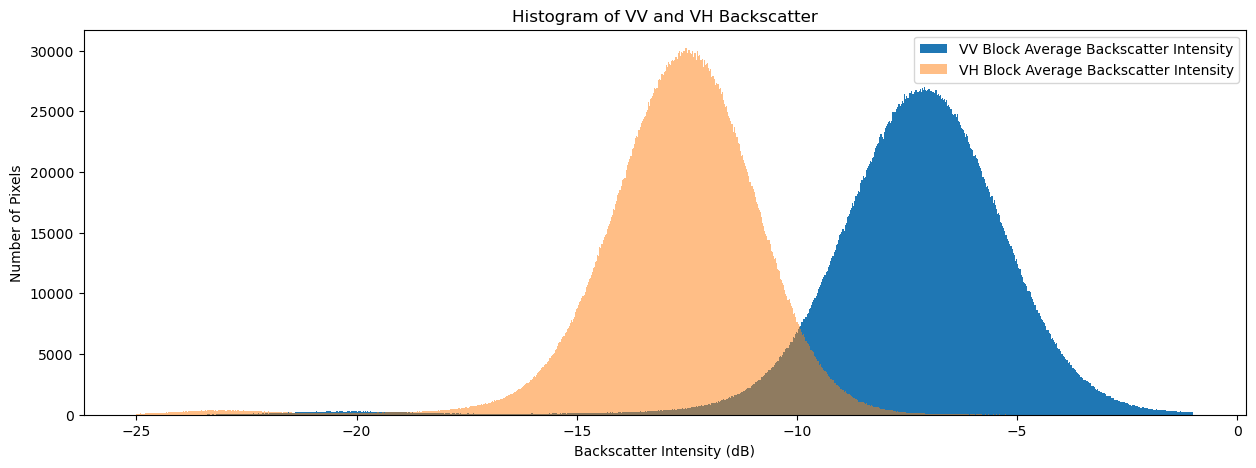

In [18]:
# Plot the filtered band values (dB)
fig = plt.figure(figsize=(15, 5))
data.filter_vv.isel(time=0).plot.hist(bins=1000,range=(-25,-1),label="VV Block Average Backscatter Intensity")
data.filter_vh.isel(time=0).plot.hist(bins=1000,range=(-25,-1),label="VH Block Average Backscatter Intensity", alpha=0.5)
plt.legend()
plt.xlabel("Backscatter Intensity (dB)")
plt.ylabel("Number of Pixels")
plt.title("Histogram of VV and VH Backscatter")
plt.show()

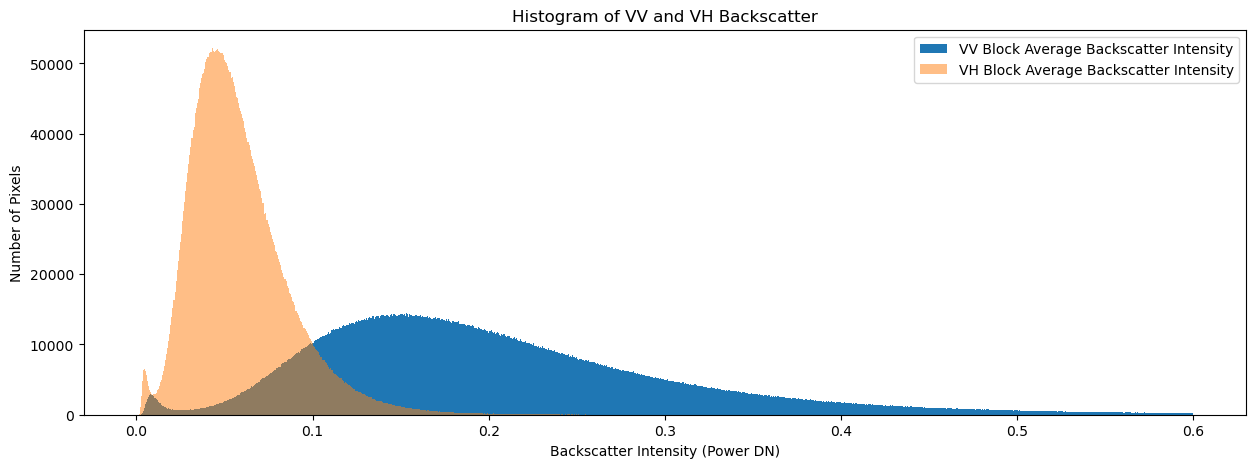

In [19]:
# Plot the unfiltered band values (power)
fig = plt.figure(figsize=(15, 5))
data.vv.isel(time=0).plot.hist(bins=1000,range=(0,0.6),label="VV Block Average Backscatter Intensity")
data.vh.isel(time=0).plot.hist(bins=1000,range=(0,0.6),label="VH Block Average Backscatter Intensity", alpha=0.5)
plt.legend()
plt.xlabel("Backscatter Intensity (Power DN)")
plt.ylabel("Number of Pixels")
plt.title("Histogram of VV and VH Backscatter")
plt.show()

## Scale the data for better image outputs
Scaling the VV and VH bands and their ratio (VV/VH) can yield improved images with better color and contrast. This is not an "exact" science and takes some "trial and error" to find the best scaling values for a particular location. The scaling below attempts to mimic the standard Sentinel-1 false-color images produced by the Sentinel SNAP toolbox.

In [20]:
vv_convert = data.vv / 60
vh_convert = data.vh / 10
data['vv_amp'] = vv_convert
data['vh_amp'] = vh_convert
data['vvvh_amp'] = (vv_convert / vh_convert) / 300 

### View a false-color RGB image
RGB Plot of Backscatter Intensity (RGB= VV, VH, VV/VH)<br>
High backscatter (both VV and VH bands) due to vegetation and foliage will appear as YELLOW (mix of red and green) or GREEN<br>
Urban areas are BRIGHT YELLOW (due to high overall scattering at both VV and VH) or MAGENTA (higher VV compared to VH)<br>
Sparsely vegetated and bare soil areas are BLUE (due to low overall scattering and higher VV compared to VH)<br>
Water is BLACK (very low backscatter in both bands with similar VV and VH)

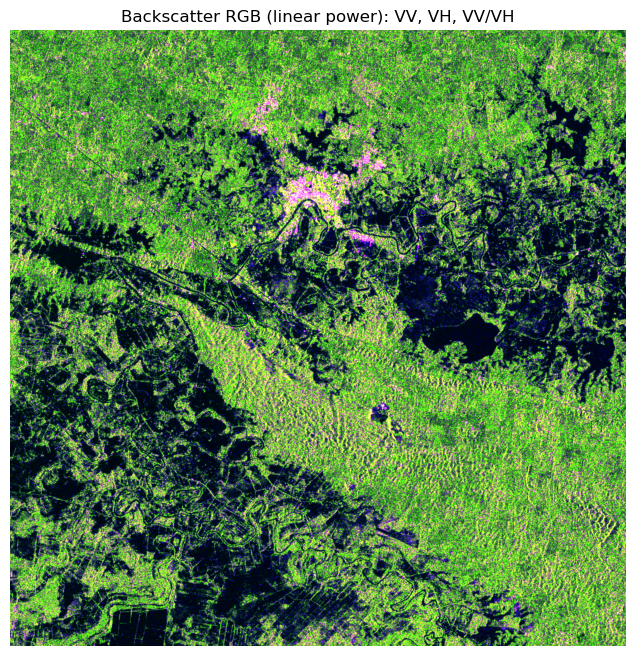

In [21]:
rgb(data.isel(time=10),bands=['vv_amp','vh_amp','vvvh_amp'], width=8)
plt.title('Backscatter RGB (linear power): VV, VH, VV/VH')
plt.axis('off')
plt.show()

## View grey-scale images
Grey scale images are useful to see contrast between vegetation and water. Below is a grey-scale time series plot of VH and a single grey-scale image for a single time slice. The time series images can be used to identify the maximum flooding state by searching for "white" regions or water. 

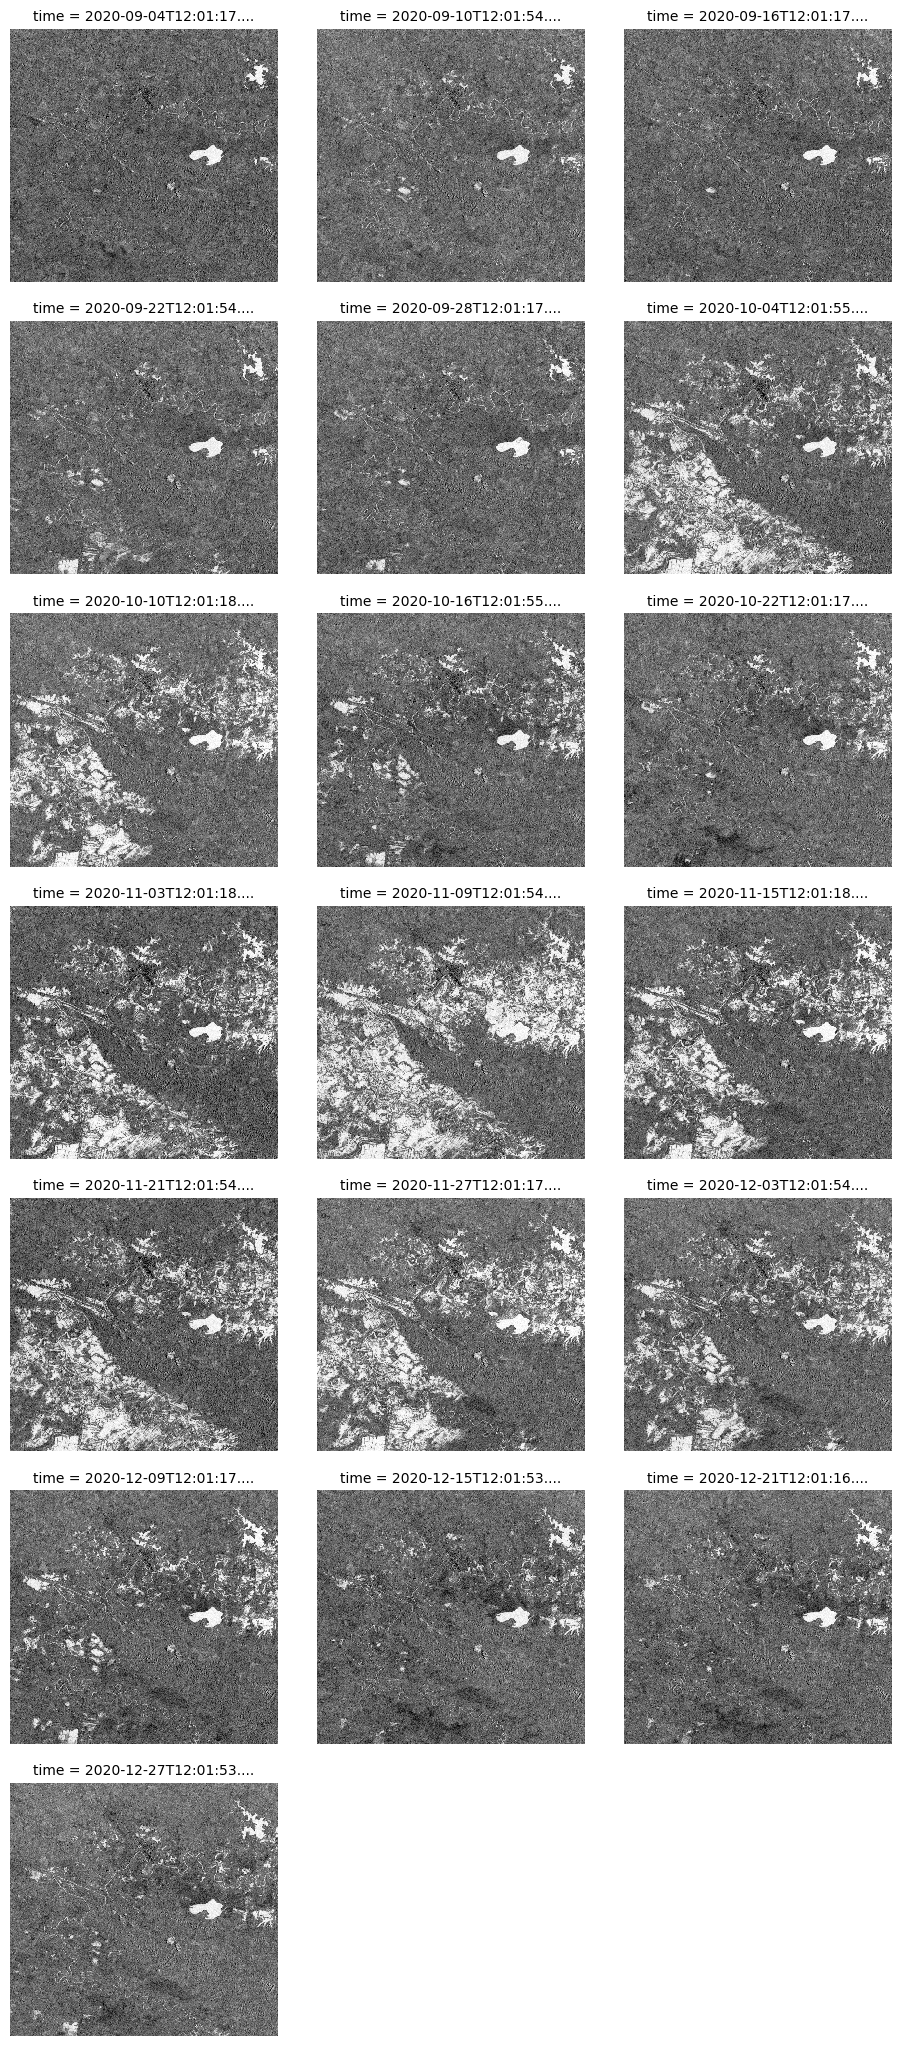

In [22]:
# Grey-scale time series plots of VH

figures = data.filter_vh.plot.imshow(col='time', col_wrap=3, vmin=-25.0, vmax=-7.0, cmap="Greys", add_colorbar=False)

# Iterate through each subplot the FacetGrid
for row in figures.axes:
    for ax in row:
        ax.axis("off")

plt.show()

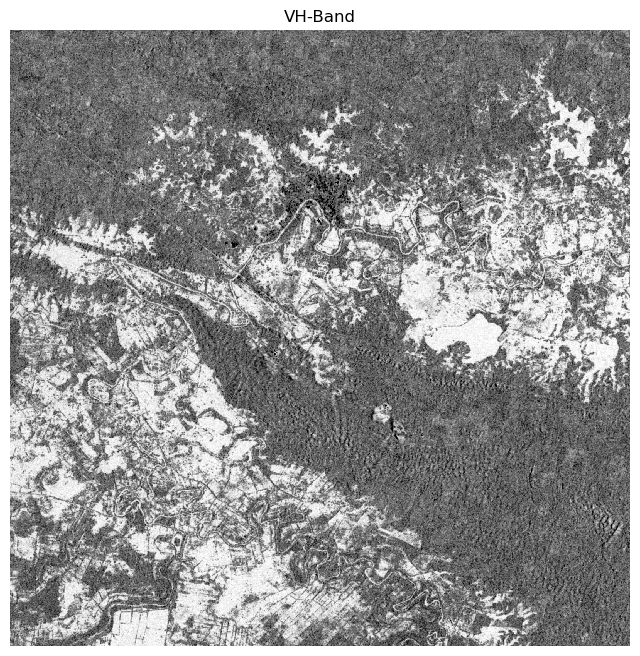

In [23]:
# Plot a single band in grey-scale
fig, ax = plt.subplots(figsize = (8,8))
data.filter_vh.isel(time=10).plot.imshow(ax=ax, robust=True, vmin=-25.0, vmax=-7.0, cmap="Greys", add_colorbar=False)
plt.title("VH-Band")
plt.axis('off')
plt.show()

## Single Date Single-Band Threshold Water Extent
The code below allows users to select a single date (use the index table), a single band (e.g. VV or VH), and a water detection threshold value for the selected band. Review the histogram plots above to be sure the threshold is reasonable. It is common to use the VH band for water detection. The final product shows the water in BLUE color against a gray-scale VH-band background image. 

In [24]:
# Select a single date, band, and threshold for water detection

single_date = 10
single_variable = 'filter_vh'
water_threshold = -21.0

In [25]:
color_blue = np.array([0,0,255]) # Water (BLUE)
scene = data.isel(time=single_date)
water = scene[single_variable].values < water_threshold

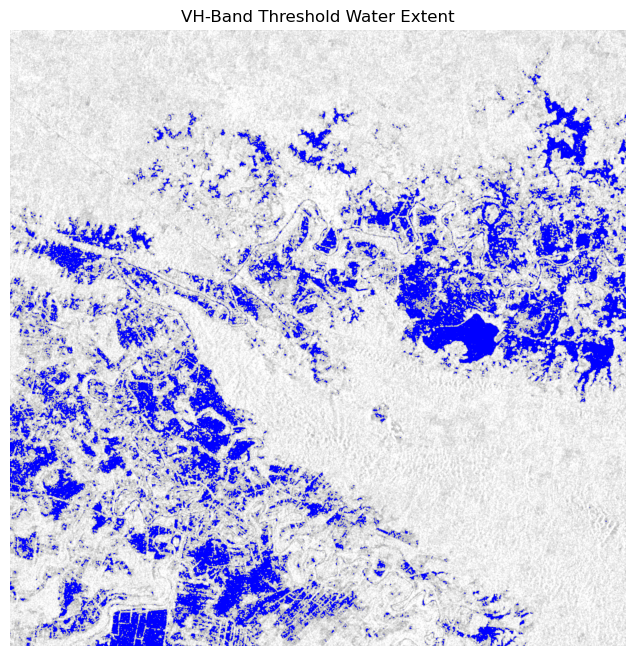

In [26]:
# Plot with water in BLUE over grey-scale VH band

rgb(scene, bands=['filter_vh', 'filter_vh', 'filter_vh'], paint_on_mask=[(water, color_blue)], width=8, min_inten=0.6)
plt.title('VH-Band Threshold Water Extent')
plt.axis('off')
plt.show()

## Multi-Date Single-Band Threshold Flooding
The code below selects two dates, a variable (VV or VH) and a change threshold. The final product performs a comparison of the two dates and calculates the change in backscatter between those dates. Pixels with significant reduction in backscatter (e.g., loss of 7 dB) are likely changes from land to water due to flooding. Finding flooding requires comparisons of images from similar viewing angles. So, it is important to only compare acquisitions with the same orbit number. You will find that the same orbit number can come from two missions (6-day separation) or one mission (12-day separation) but the pass direction (ascending or descending) will be the same. 

In [27]:
# Select TWO acquisitions to calculate a change product
# Choose from the indices in the data table above
# first_time = First time index in dataset 
# second_time = Second time index in dataset 

first_time = 0
second_time = 10

In [28]:
# Select the variable to plot: vv or vh

threshold_variable = 'filter_vh'

# The code will calculate the difference of the two images (Second-First)
# Define a threshold range to compare the difference of the two acquisitions
# GREY = Pixels NOT in the threshold range 
# RED = Pixels LESS than the low end of the threshold range

change_threshold = -7

In [29]:
# Set the overlay colors
# Calculate the difference in backscatter between the two times
# Find the pixels above or below the threshold range (these are significant changes)

color_loss = np.array([255,0,0]) # backscatter decrease (RED)
color_black = np.array([0,0,0]) # low backscatter change, water (BLACK)
color_blue = np.array([0,0,255]) # Water (BLUE)

first_time_data = data.isel(time=first_time)
second_time_data = data.isel(time=second_time)
change_product = second_time_data[threshold_variable] - first_time_data[threshold_variable]
below_threshold = change_product.values < change_threshold

In [30]:
# Set the water threshold value based on data in the histograms for the selected band
# This will "mask" the water pixels in the first acquisition

water = first_time_data[threshold_variable].values < water_threshold

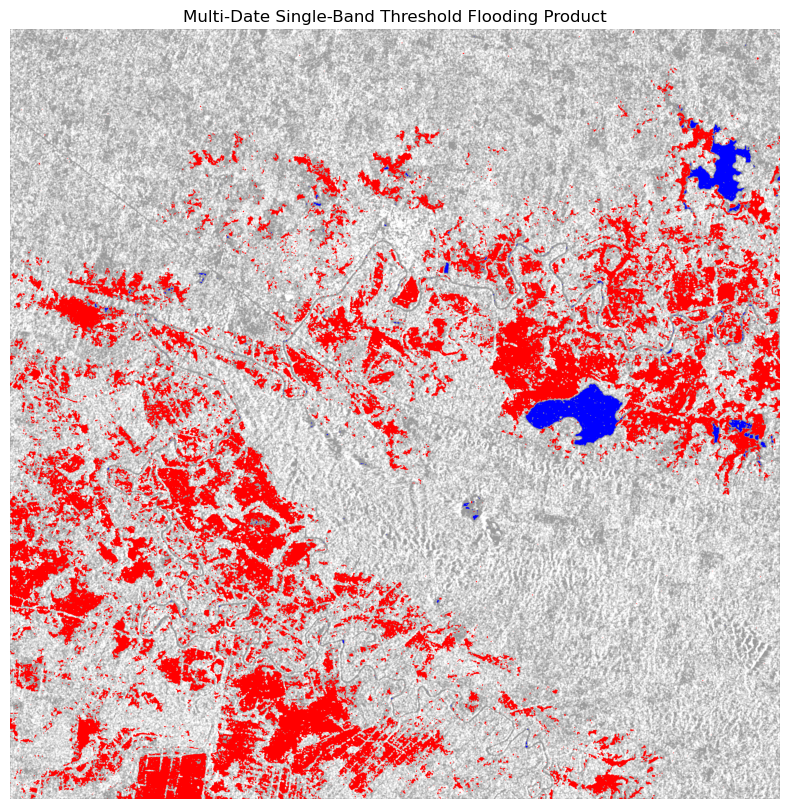

In [31]:
# Create a custom threshold plot to identify flooding
# The background image VV backscatter (grey-scale)
# RED areas have decreased backscatter indicative of new flooding
# BLUE areas are water in the first acquisition 

rgb(first_time_data, bands=['filter_vh', 'filter_vh', 'filter_vh'], 
    paint_on_mask=[(below_threshold, color_loss),(water, color_blue)], width=10, min_inten=0.6)
plt.title('Multi-Date Single-Band Threshold Flooding Product')
plt.axis('off')
plt.show()

## Plot the Time Series Water Extent

In [32]:
# Find all of the water pixels using the VH threshold
water_time = ((data[single_variable] < water_threshold))

In [33]:
# Each pixel is 10m x 10m, so 100 square meters in area
# We convert square meters to square kilometers for the plot scale

out = []
for obj in water_time:
    total = obj.values.sum()*100/1000/1000
    day = [total]
    out.append(day)

In [34]:
water_pixels = out
scene2 = data.time.dt.date.values

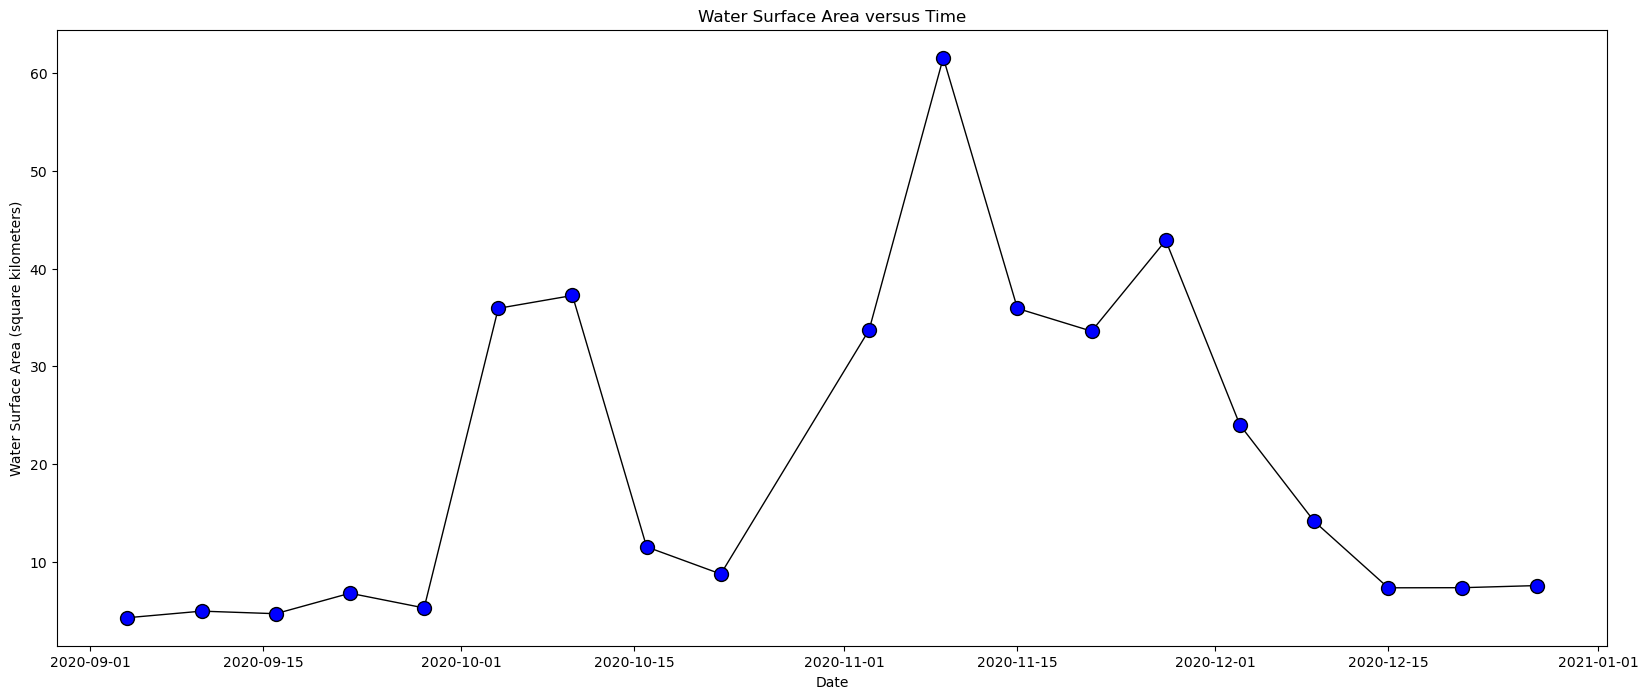

In [35]:
plt.figure(figsize=(20,8))
plt.plot(scene2, water_pixels, c='black', marker='o', mfc='blue', markersize=10, linewidth=1)
plt.title('Water Surface Area versus Time')
plt.xlabel('Date')
plt.ylabel('Water Surface Area (square kilometers)')
plt.show()